In [14]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
from pathlib import Path

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

# Seaborn for plotting and styling
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


params = {'legend.fontsize' :  10,
          'figure.figsize'  :  (10, 10),
          'axes.labelsize'  :  14,
          'axes.titlesize'  :  14,
          'xtick.labelsize' :  15,
          'ytick.labelsize' :  15}
plt.rcParams.update(params)

In [3]:
#choose filepath to desired data
path = '/Volumes/KESU/apr06/cal_target/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [4]:
waves= np.linspace(7,12,61)
lps = np.round(np.linspace(0,350,36),1)

In [33]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 115; ymax1 = 175;

FOV = 53.51 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [6]:
'''LOAD slope from 2 point NUC'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC.h5" 

hf = h5py.File(save_path+name, 'r')
M1 = hf.get('M1')
M2 = hf.get('M2')
T1 = hf.get('Tref1')
T2 = hf.get('Tref2')

In [7]:
#first, determine reference temp for each camera
df_ref = create_LUT_df(path,'ref.h5')

tref1 =  df_ref['temps1'].value_counts().idxmax() #most common FPA temp
tref2 =  df_ref['temps2'].value_counts().idxmax() #most common FPA temp

print('Ref T1 is '+ str(tref1))
print('Ref T2 is '+ str(tref2))

Ref T1 is 37.8
Ref T2 is 38.3


In [11]:
#load dark field correction
df_dark = create_LUT_df(path,'dark.h5')

#correct DFC images for reference temp

'''determine DFC in camera 1 '''
D1s = [];
for i in range(len(df_dark)):
    corr = (tref1 - df_dark['temps1'][i])*M1
    offset = (df_dark['imgs1'][i]- corr)
    D1s.append(offset)
D1 = np.mean(D1s, axis =0)    
    
'''determine DFC in camera 1 '''
D2s = [];
for i in range(len(df_dark)):
    corr   = (tref2 - df_dark['temps2'][i])*M2
    offset = (df_dark['imgs2'][i]- corr)
    D2s.append(offset)
D2 = np.mean(D2s, axis =0)    

In [12]:
def DFC(im,t,tref,D,M):
    dark_corr = D + (tref-t)*M
    return(im-dark_corr)

def apply_DFC_to_df(df,D1,D2,tref1,tref2,M1,M2):
    imgs1 = []; temps1 = []
    imgs2 = []; temps2 = []
    for i in range(len(df)):
        im1  = df['imgs1'][i]
        t1   = df['temps1'][i]
        im1c =DFC(im1,t1,tref1,D1,M1)# take offset
        im1c = im1c + (tref1-t1)*M1 #rescale gain
        
        im2  = df['imgs2'][i]
        t2   = df['temps2'][i]
        im2c =DFC(im2,t2,tref2,D2,M2) 
        im2c = im2c + (tref2-t2)*M2 #rescale gain

        imgs1.append(im1c);temps1.append(t1)
        imgs2.append(im2c);temps2.append(t2)
        
    data_corrected = {'imgs1': imgs1,'imgs2': imgs2,'temps1': temps1, 'temps2' : temps2}
    df_corrected = pd.DataFrame.from_dict(data_corrected)
    return(df_corrected)

In [19]:
file_path = Path('/Volumes/KESU/apr06/cal_target/')
files = list(file_path.glob('*.h5'))
df_list = []
df_names = []

for file_name in files:
    fn = file_name.as_posix()
    df = create_LUT_df('',fn)
    df['Name'] = fn[31:]
    df_list.append(df)
    df_names.append(fn[31:])

In [20]:
#apply pixel registration and NUC to full dataset
mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]
t1s = []
t2s = []

for i in range(len(df_names)):
    #will create a df and print the names of the keys in the original hdf5 file
    df_i = create_LUT_df(path,df_names[i])
    
    #apply 2 point NUC, this df cooresponds to Cij
    df = apply_DFC_to_df(df_i,D1,D2,tref1,tref2,M1,M2)
    
    corrected_images1= [] ; 
    corrected_images2= [] ; 
    
    for i in range(len(df)):
        #load image
        rn = df['imgs1'][i];
        
        #apply pixel registration, this returns C lambda, phi
        T  = df['temps1'][i];
        t1s.append(T)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        corrected_images1.append(cn)
  

    for i in range(len(df)):
        #load image
        rn = df['imgs2'][i];
        
        #apply pixel registration
        T  = df['temps2'][i];
        t2s.append(T)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        corrected_images2.append(cn)
        

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))

    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))

In [21]:
df = {'name': df_names, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}


In [22]:
df = pd.DataFrame.from_dict(df, orient='index')
df = df.transpose()

In [23]:

df.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_target.h5', key='s')


/Users/kirahart/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['name', 'ims1', 's1', 'ims2', 's2'], dtype='object')]

  pytables.to_hdf(


In [24]:
def finv(y,A,B):
    return np.abs(((y-B)/A))**0.5


In [62]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "LUT2.h5" 

hf = h5py.File(save_path+name, 'r')
gamma1 = hf.get('gamma1')
gamma2 = hf.get('gamma2')
A1     = hf.get('A1')
A2     = hf.get('A2')
At     = hf.get('At')
B1     = hf.get('B1')
B2     = hf.get('B2')
Bt     = hf.get('Bt')

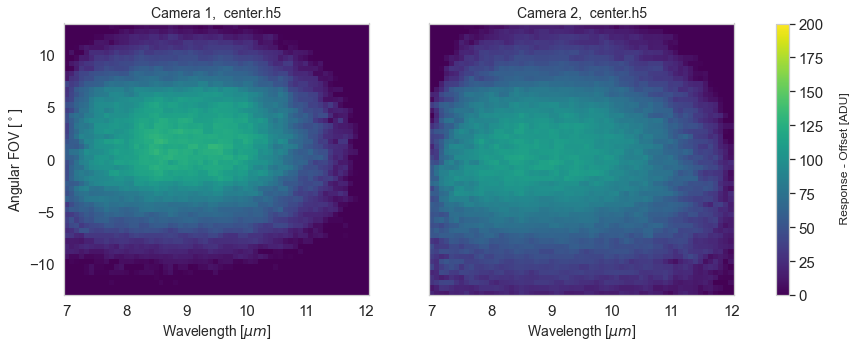

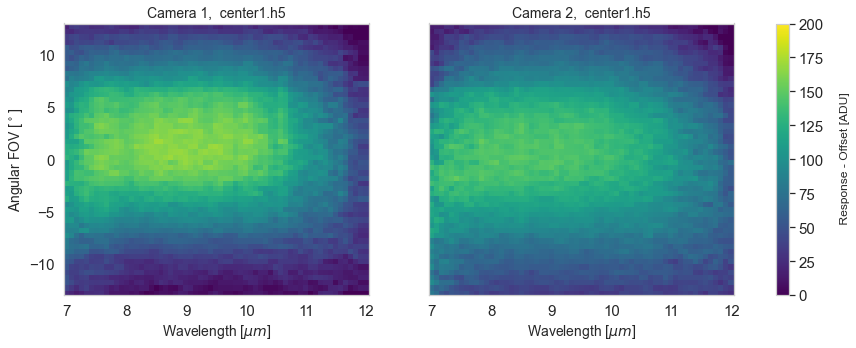

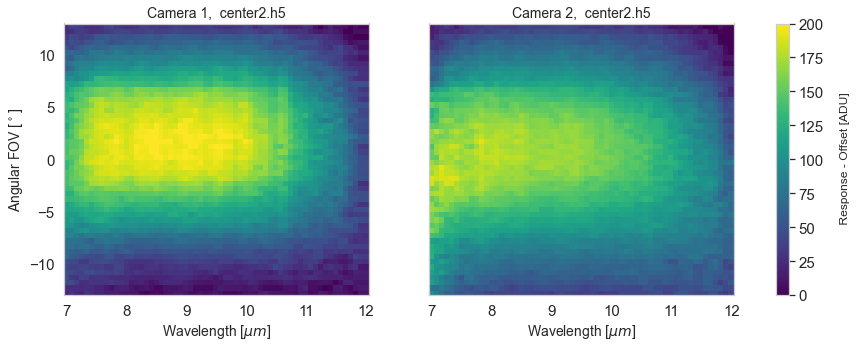

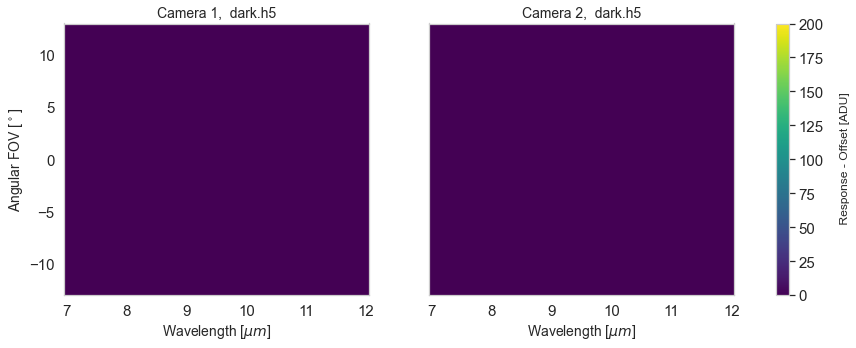

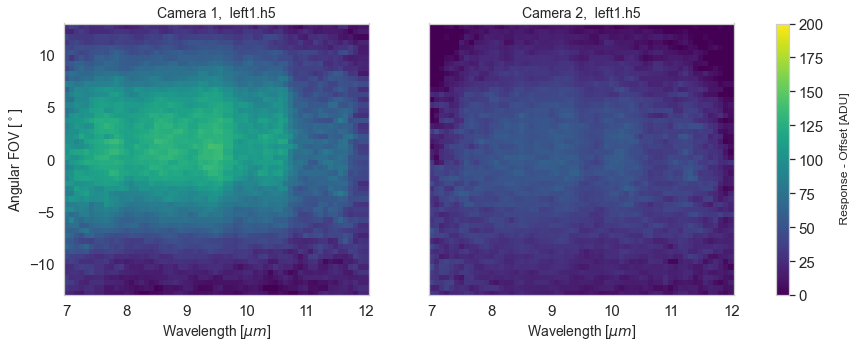

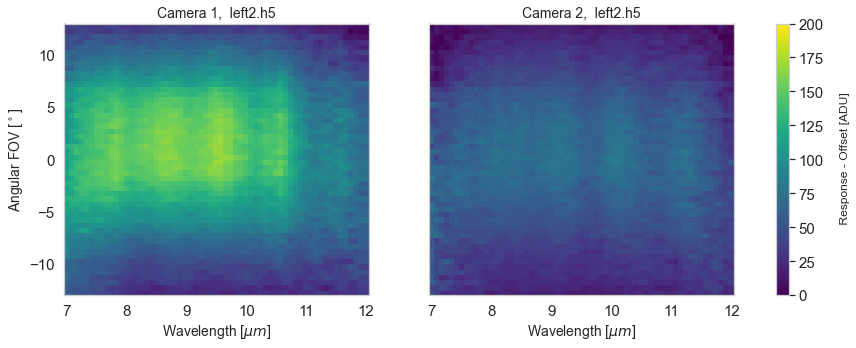

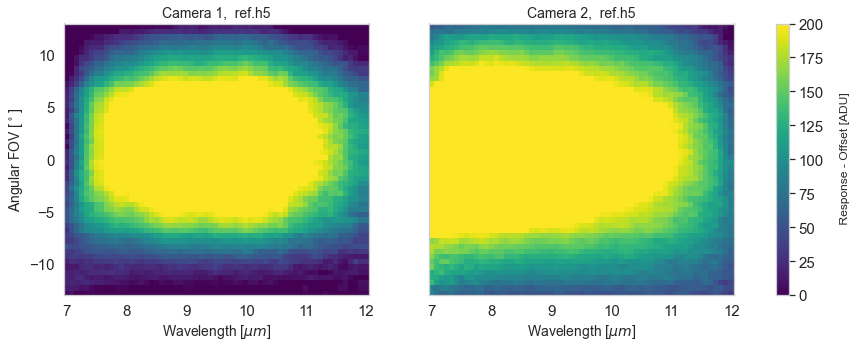

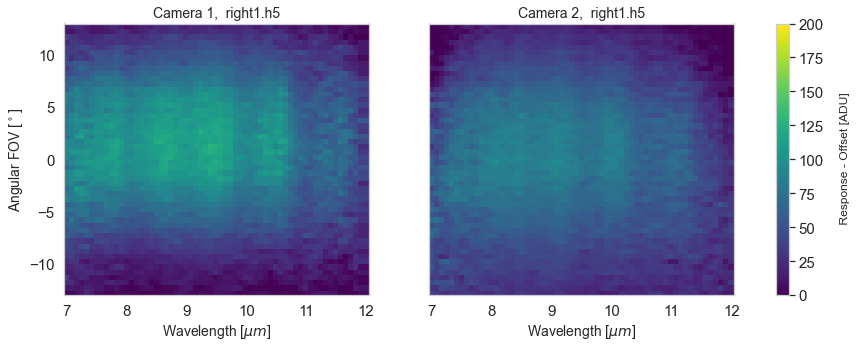

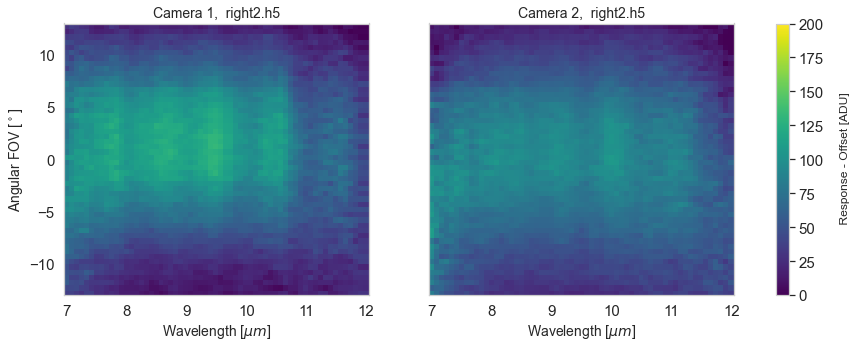

In [37]:
X,Y = np.meshgrid(waves,angles)
spath = '/Volumes/KESU/mar02/polarized/images/'

for j in range(len(df)):
    I1 = (df['ims1'][j])/gamma1
    I2 = (df['ims2'][j])/gamma2 
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)

    pl1 = axes[0].pcolormesh(X,Y,I1 ,shading ='auto' ,cmap = "viridis")
    pl1.set_clim([0,200])
    axes[0].set_ylabel('Angular FOV [$^\circ$]')
    axes[0].set_xlabel('Wavelength [$\mu m$]')
    axes[0].set_title('Camera 1,  ' + df_names[j])


    pl2 = axes[1].pcolormesh(X,Y,I2,shading ='auto' ,cmap = "viridis")
    pl2.set_clim([0,200])
    axes[1].set_xlabel('Wavelength [$\mu m$]')
    axes[1].set_title('Camera 2,  ' + df_names[j])

    cbar = fig.colorbar(pl1, ax=axes.ravel().tolist())
    cbar.ax.set_ylabel('\n Response - Offset [ADU]',fontsize = 12)

    fig.savefig(spath +'plot'+str(j)+'.png')

In [39]:
df_names

['center.h5',
 'center1.h5',
 'center2.h5',
 'dark.h5',
 'left1.h5',
 'left2.h5',
 'ref.h5',
 'right1.h5',
 'right2.h5']

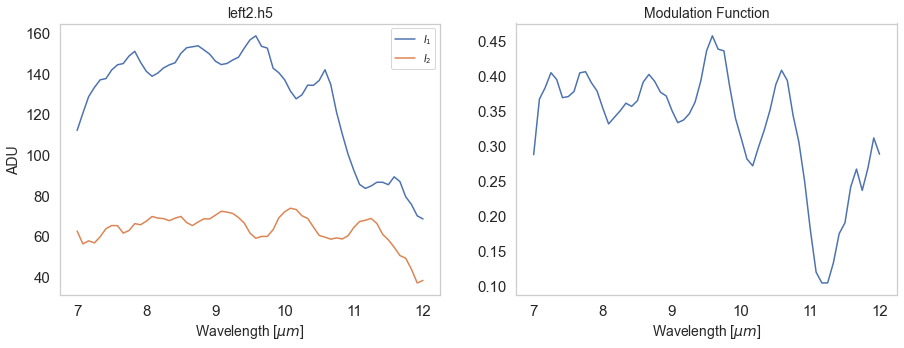

In [48]:
j =5

I1 = (df['ims1'][j][20:40])/gamma1
I2 = (df['ims2'][j][20:40])/gamma2 

mod = (I1-I2)/(I1+I2)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =False)

axes[0].plot(waves,np.mean(I1,0),label = '$I_1$')
axes[0].plot(waves,np.mean(I2,0),label = '$I_2$')
axes[0].set_ylabel('ADU')
axes[0].set_xlabel('Wavelength [$\mu m$]')
axes[0].set_title(df_names[j] )
axes[0].legend()


pl2 = axes[1].plot(waves,np.mean(mod,0))
axes[1].set_xlabel('Wavelength [$\mu m$]')
axes[1].set_title('Modulation Function')

plt.show()

In [55]:
def radiometric_retrieval(df,j,At,Bt):
    #attempt retrival
    Ts= np.zeros([25,len(waves)])
    for w in range(len(waves)):
        for s in range(25):
            data= list(df['ims1'][j]+df['ims2'][j])[s][w]
            A = At[s][w]
            B = Bt[s][w]
            t = finv(data,A,B)
            Ts[s][w] = t
    return(Ts)       

In [58]:
#now, define inverse fit function, note this is broken
def finv(R,A,B):
    return (R-B)/A

In [136]:
j =8

I1 = np.mean((df['ims1'][j][20:40])/gamma1,axis = 0)
I2 = np.mean((df['ims2'][j][20:40])/gamma2,axis = 0)

In [137]:
dt = waves[1]-waves[0]
freq = np.fft.fftfreq(len(I1), dt)
ft1 = np.fft.fft(I1) * dt
ft2 = np.fft.fft(I2) * dt

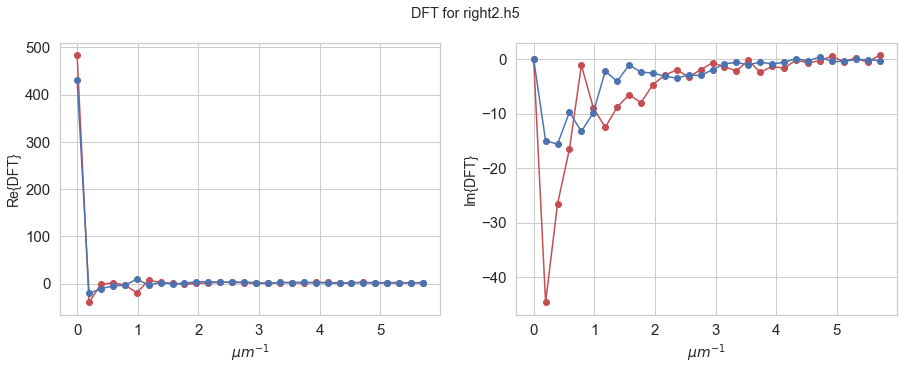

In [138]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =False)
axes[0].plot(freq[:30],np.real(ft1[:30]), 'r-o')
axes[1].plot(freq[:30],np.imag(ft1[:30]), 'r-o')
axes[0].plot(freq[:30],np.real(ft2[:30]), 'b-o')
axes[1].plot(freq[:30],np.imag(ft2[:30]), 'b-o')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_ylabel('Re{DFT}')
axes[1].set_ylabel('Im{DFT}')
axes[0].set_xlabel('$\mu m ^{-1}$')
axes[1].set_xlabel('$\mu m ^{-1}$')

plt.suptitle("DFT for " + df_names[j])

plt.show()

<ipython-input-90-f6e7c0610b57>:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf